In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("hourly-energy-consumption/PJME_hourly.csv")
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [3]:
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [4]:
df.tail()

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

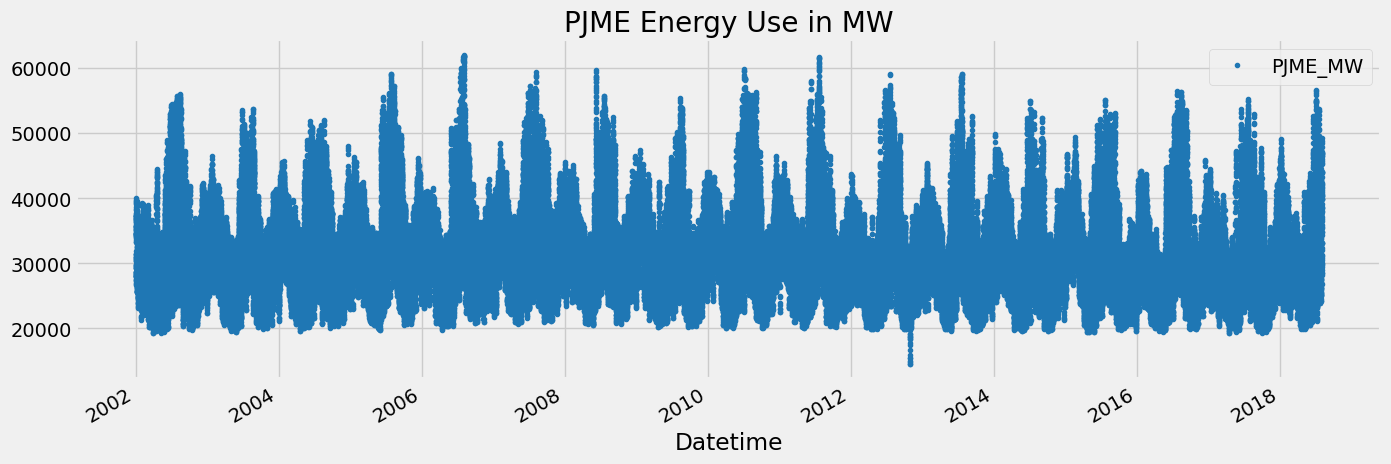

In [5]:
df.plot(style=".",
        figsize=(15,5),
        color=color_pal[0],
        title="PJME Energy Use in MW")

<Axes: ylabel='Frequency'>

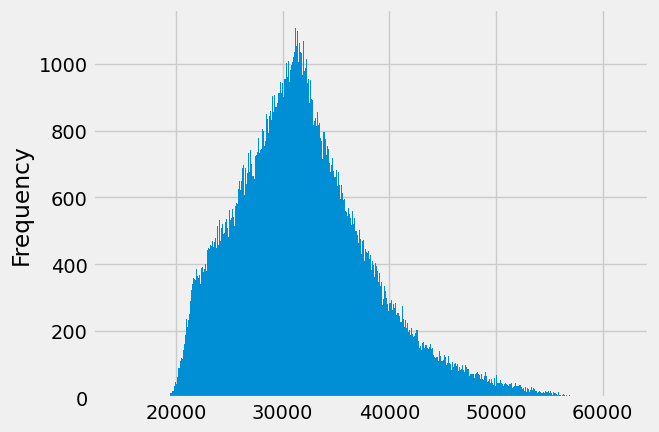

In [6]:
df["PJME_MW"].plot(kind="hist", bins=500)

<Axes: xlabel='Datetime'>

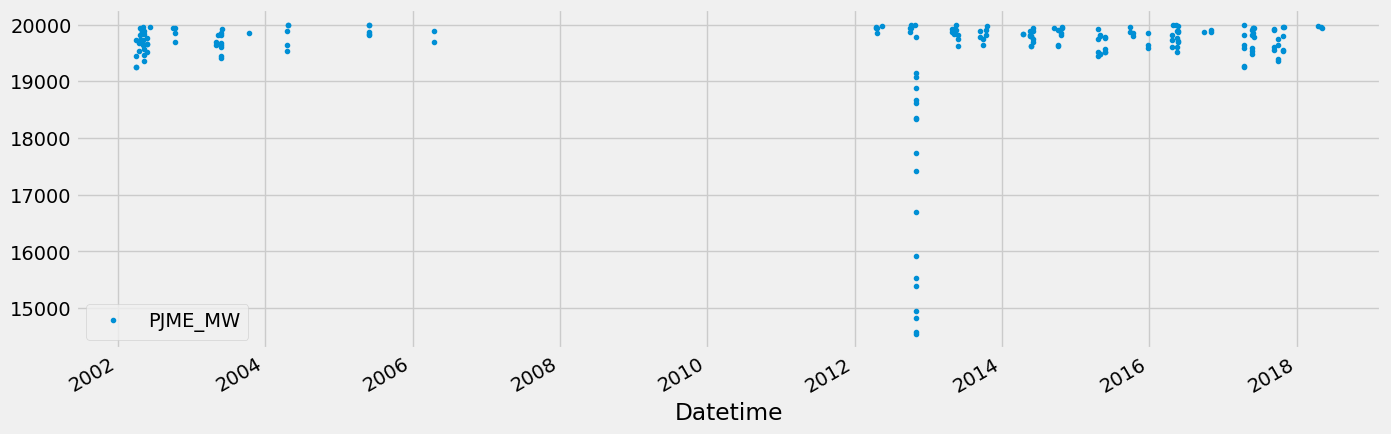

In [8]:
df.query("PJME_MW < 20_000").plot(figsize=(15,5), style=".")

<Axes: xlabel='Datetime'>

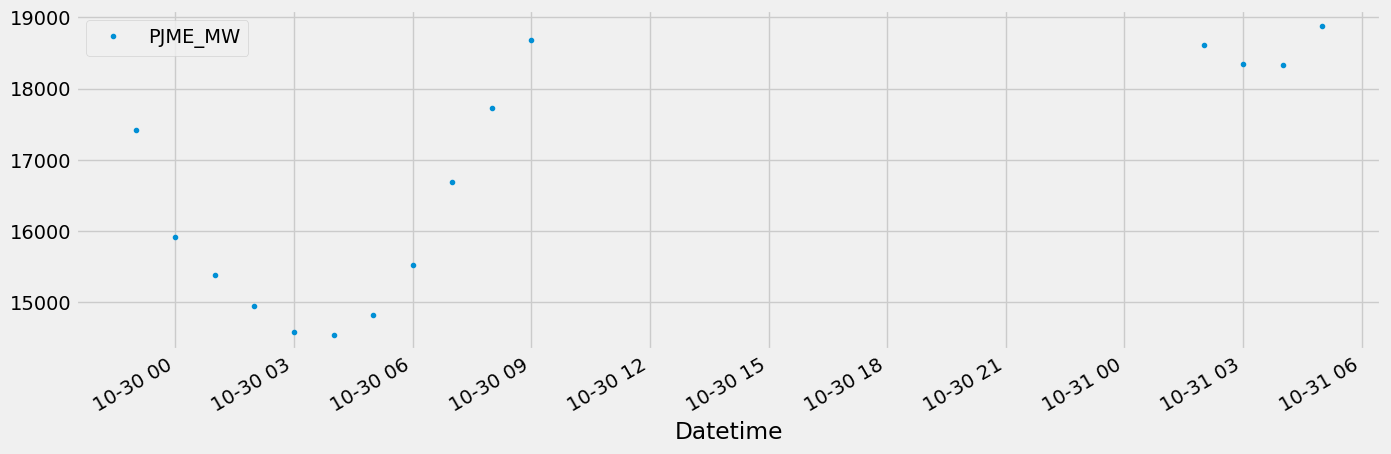

In [9]:
df.query("PJME_MW < 19_000").plot(figsize=(15,5), style=".")

In [10]:
df = df.query("PJME_MW > 19_000").copy()

In [13]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

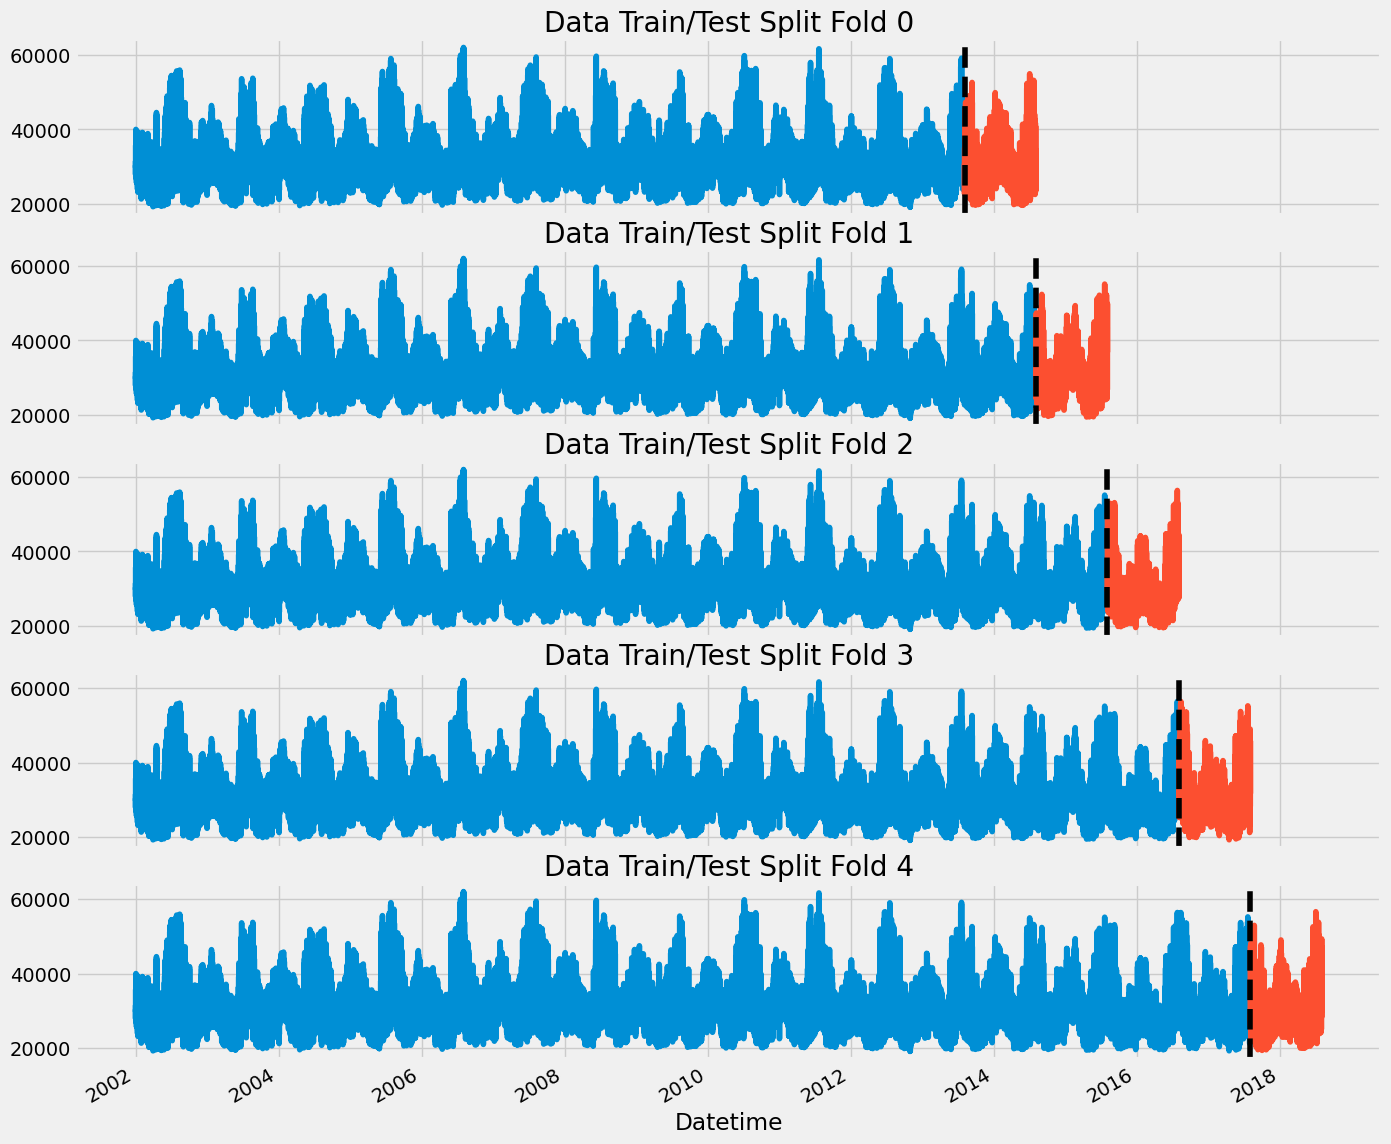

In [14]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["PJME_MW"].plot(ax=axs[fold],
                          label="Training Set",
                          title=f"Data Train/Test Split Fold {fold}")
    test["PJME_MW"].plot(ax=axs[fold],
                         label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1

In [16]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()

    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear

    return df

In [17]:
df = create_features(df=df)

In [19]:
def add_lags(df):
    """
    Create Lag Features.
    """
    df = df.copy()

    target_map = df["PJME_MW"].to_dict()
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)

    return df

In [20]:
df = add_lags(df=df)

In [21]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39525.0,38698.0,37330.0


In [24]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'lag1', 'lag2', 'lag3']
    TARGET = "PJME_MW"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5,
                           booster="gbtree",
                           n_estimators=2000,
                           early_stopping_rounds=50,
                           objective="reg:linear",
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=200)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


/home/edaerer/Documents/CODE/Python/time-series-analysis-rob-mulla/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [19:00:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


/home/edaerer/Documents/CODE/Python/time-series-analysis-rob-mulla/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [19:00:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[1000]	validation_0-rmse:3166.00495	validation_1-rmse:3420.12751
[1200]	validation_0-rmse:3116.88016	validation_1-rmse:3410.81044
[1397]	validation_0-rmse:3071.35674	validation_1-rmse:3410.68796
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


/home/edaerer/Documents/CODE/Python/time-series-analysis-rob-mulla/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [19:00:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.21239
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.25153
[411]	validation_0-rmse:3475.26636	validation_1-rmse:3503.58192
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


/home/edaerer/Documents/CODE/Python/time-series-analysis-rob-mulla/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [19:00:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:5738.32648	validation_1-rmse:5794.44193
[400]	validation_0-rmse:3499.03653	validation_1-rmse:4172.17589
[600]	validation_0-rmse:3324.23232	validation_1-rmse:4104.78293
[800]	validation_0-rmse:3249.57813	validation_1-rmse:4082.05429
[1000]	validation_0-rmse:3198.19331	validation_1-rmse:4049.03566
[1200]	validation_0-rmse:3156.45228	validation_1-rmse:4026.36730
[1400]	validation_0-rmse:3117.12664	validation_1-rmse:4009.77246
[1600]	validation_0-rmse:3082.05985	validation_1-rmse:3999.59529
[1800]	validation_0-rmse:3053.75518	validation_1-rmse:3992.42876
[1999]	validation_0-rmse:3029.32024	validation_1-rmse:3974.96253
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


/home/edaerer/Documents/CODE/Python/time-series-analysis-rob-mulla/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [19:00:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:5752.09311	validation_1-rmse:5610.63120
[400]	validation_0-rmse:3541.03825	validation_1-rmse:3998.83825
[439]	validation_0-rmse:3482.71629	validation_1-rmse:4002.30426


In [36]:
print(f"Score across folds: {np.mean(scores).round(4)}")
print(f"Fold Scores: {np.array(scores).round(4)}")

Score across folds: 3723.6245
Fold Scores: [3760.8277 3409.4787 3477.9504 3974.9625 3994.903 ]


# Predicting the Future

In [37]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39525.0,38698.0,37330.0


In [39]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'lag1', 'lag2', 'lag3'],
      dtype='object')

In [47]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'lag1', 'lag2', 'lag3']
TARGET = 'PJME_MW'

X = df[FEATURES]
y = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster="gbtree",
                       n_estimators=1000,
                       objective="reg:linear",
                       max_depth=3,
                       learning_rate=0.01)

In [48]:
reg.fit(X, y,
        eval_set=[(X, y)],
        verbose=200)

[0]	validation_0-rmse:32403.88991


/home/edaerer/Documents/CODE/Python/time-series-analysis-rob-mulla/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [19:15:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:5753.18185
[400]	validation_0-rmse:3569.04143
[600]	validation_0-rmse:3401.19834
[800]	validation_0-rmse:3333.82963
[999]	validation_0-rmse:3285.94624


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [49]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [57]:
future = pd.date_range("2018-08-03", "2019-08-03", freq="1h")
future_df = pd.DataFrame(index=future)
future_df["isFuture"] = True
df["isFuture"] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [60]:
df_and_future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-02 20:00:00,NaN,20,4,3,8,2019,214,NaN,43606.0,40513.0,True
2019-08-02 21:00:00,NaN,21,4,3,8,2019,214,NaN,41863.0,39840.0,True
2019-08-02 22:00:00,NaN,22,4,3,8,2019,214,NaN,40005.0,38664.0,True
2019-08-02 23:00:00,NaN,23,4,3,8,2019,214,NaN,37174.0,36125.0,True


In [61]:
future_with_features = df_and_future.query("isFuture").copy()

In [62]:
future_with_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-02 20:00:00,NaN,20,4,3,8,2019,214,NaN,43606.0,40513.0,True
2019-08-02 21:00:00,NaN,21,4,3,8,2019,214,NaN,41863.0,39840.0,True
2019-08-02 22:00:00,NaN,22,4,3,8,2019,214,NaN,40005.0,38664.0,True
2019-08-02 23:00:00,NaN,23,4,3,8,2019,214,NaN,37174.0,36125.0,True


In [63]:
future_with_features["pred"] = reg.predict(future_with_features[FEATURES])

<Axes: title={'center': 'Future Predictions'}>

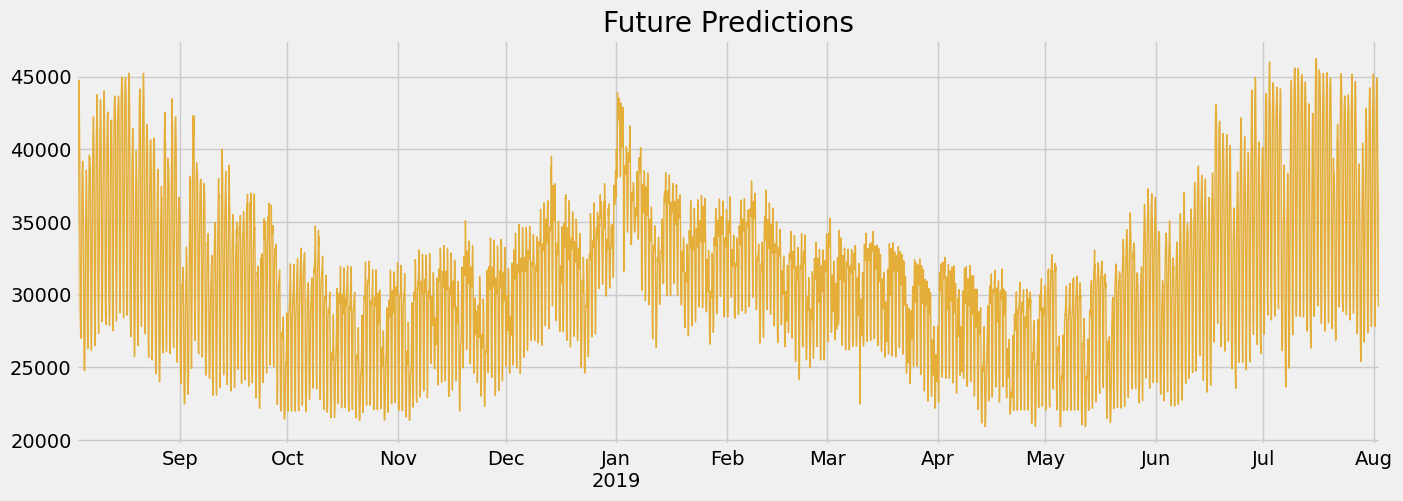

In [66]:
future_with_features["pred"].plot(figsize=(15,5),
                                  color=color_pal[2],
                                  ms=1,
                                  lw=1,
                                  title="Future Predictions")

# Save your Models

In [68]:
reg.get_booster().save_model("model.json")

In [69]:
# Load the saved model

reg_new = xgb.XGBRegressor()

reg_new.load_model("model.json")

<Axes: title={'center': 'Future Predictions'}>

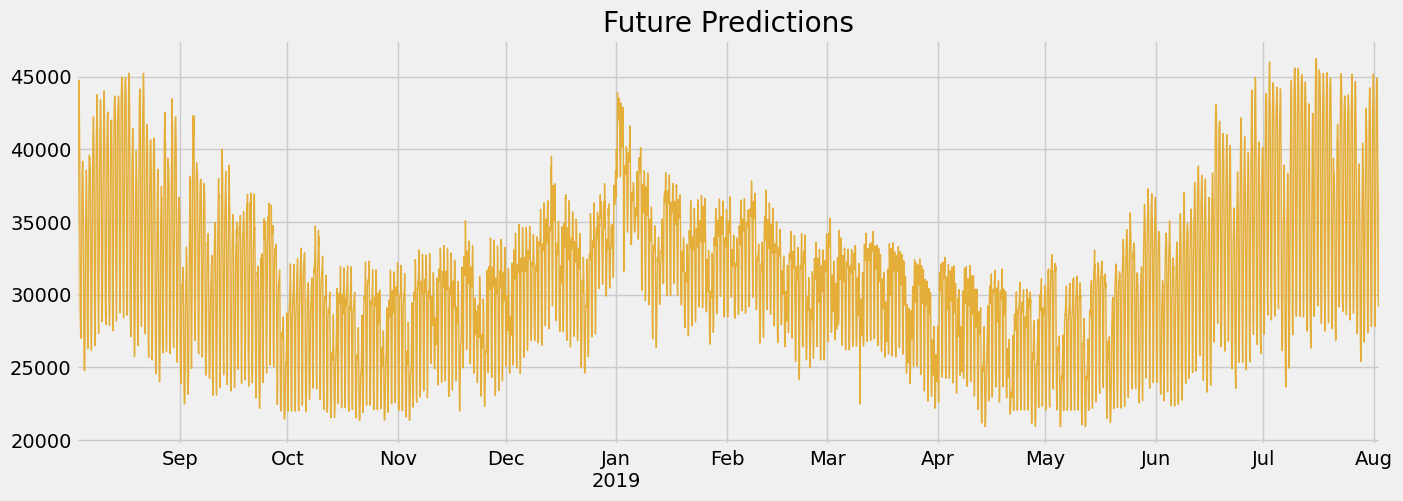

In [79]:
future_with_features["pred"] = reg_new.predict(future_with_features[FEATURES])
future_with_features["pred"].plot(figsize=(15,5),
                                  color=color_pal[2],
                                  ms=1,
                                  lw=1,
                                  title="Future Predictions")